## Assignment 4 - Health Care Fraud Detection

## Section 1: Data Prep <a class="anchor" id="Section_1"></a>

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import plotly.express as px
import scipy.stats as stats
import plotly.io as pio
pio.renderers.default = "notebook"

In [21]:
data = pd.read_csv("inpatientCharges.csv")
data.columns = ['DRG','Provider_Id', 'Provider_Name','Provider_StreetAddress','Provider_City',
               'Provider_State','Provider_Zipcode','Hospital_referral_region_desp',
                'Total_Discharges','Average_Covered_Charges','Average_Total_Payments',
                'Average_Medicare_Payment']
data = data.drop('Average_Covered_Charges',axis=1)

# Change data type and transfer spending amount with dollar sign into numeric
data['DRG'] = data['DRG'].astype('category')
data['Provider_State'] = data['Provider_State'].astype('category')
data['Provider_City'] = data['Provider_City'].astype('category')
data['Provider_Id'] = data['Provider_Id'].astype('category')
data['Hospital_referral_region_desp'] = data['Hospital_referral_region_desp'].astype('category')
data['Average_Total_Payments'] = (data['Average_Total_Payments']
                              .str.replace(r'[^-+\d.]', '').astype(float))
data['Average_Medicare_Payment'] = (data['Average_Medicare_Payment']
                              .str.replace(r'[^-+\d.]', '').astype(float))

data.head()

C:\Users\Jessica\AppData\Local\Temp\ipykernel_17664\1883067601.py:14: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Jessica\AppData\Local\Temp\ipykernel_17664\1883067601.py:16: FutureWarning:

The default value of regex will change from True to False in a future version.



,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,5777.24,4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,5787.57,4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,5434.95,4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,5417.56,4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,5658.33,4851.44


## Section 2: Features <a class="anchor" id="Section_3"></a>

### Section 2.1a DRG's 95% CI of Average Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may heavily abuse the resources compared to the 95% of its peers of the same DRG.**

In [22]:
grouped = data.groupby(['DRG'])['Average_Total_Payments']
mean = grouped.mean()
std = grouped.std()

# Create a benchmark within 95% of confidence interval
drg_95 = pd.DataFrame({'Mean': mean, 'Std': std})

# add the new feature average spending to the dataset 
drg_95 = data.merge(drg_95, on='DRG', how='left')

drg_95['upper_CI'] = np.where(drg_95['Mean']==0, 0, drg_95['Mean'] + 1.96*drg_95['Std'])
drg_95.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Mean,Std,upper_CI
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,5777.24,4763.73,6960.534004,1477.873952,9857.166949
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,5787.57,4976.71,6960.534004,1477.873952,9857.166949
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,5434.95,4453.79,6960.534004,1477.873952,9857.166949
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,5417.56,4129.16,6960.534004,1477.873952,9857.166949
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,5658.33,4851.44,6960.534004,1477.873952,9857.166949


In [23]:
#Filter out average total payment is over 95% of the upper confidence interval
outlier = drg_95[(drg_95['Average_Total_Payments']>drg_95['upper_CI']) & (drg_95['upper_CI'] >= 0)] 
filtered_outlier = outlier[['DRG', 'Provider_Name', 'Average_Total_Payments', 'upper_CI']]

filtered_outlier.head()

,DRG,Provider_Name,Average_Total_Payments,upper_CI
31,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,FLAGSTAFF MEDICAL CENTER,11026.33,9857.166949
36,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SUMMIT HEALTHCARE REGIONAL MEDICAL CENTER,10000.82,9857.166949
67,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,MERCY GENERAL HOSPITAL,10863.22,9857.166949
73,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,GLENDALE MEM HOSPITAL & HLTH CENTER,11082.18,9857.166949
88,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,JOHN MUIR MEDICAL CENTER - WALNUT CREEK CAMPUS,12355.85,9857.166949


### Section 2.1b DRG's of Average Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of average total payments from its peers with the same DRG.**

In [24]:
drg_avg = data.groupby(['DRG'])['Average_Total_Payments'].mean().reset_index()
drg_avg.columns = ['DRG','Avg_Payment_ByStateDRG']

drg_avg = pd.merge(data, drg_avg, how='left', on=['DRG'])
 
drg_avg['drg_avg_ratio'] = np.where(drg_avg['Avg_Payment_ByStateDRG']==0,0, drg_avg['Average_Total_Payments'] / drg_avg['Avg_Payment_ByStateDRG'])
drg_avg['drg_avg_ratio'].describe()

count    163065.000000
mean          1.000000
std           0.248259
min           0.464005
25%           0.839686
50%           0.928391
75%           1.085989
max           9.449417
Name: drg_avg_ratio, dtype: float64

### Section 2.1c DRG's of Median Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of median total payments from its peers with the same DRG. Also, median benchmark is somewhat useful compared to average measurement because the outliers could distort the mean values of data.**

In [25]:
med_drg = data.groupby(['DRG'])['Average_Total_Payments'].mean() 
med_drg = pd.DataFrame(med_drg)
med_drg.columns = ['Median_avg_total_payments']

# add the new feature median spending to the dataset 
med_drg = pd.merge(data, med_drg, how='left', on=['DRG'])

med_drg['drg_median_ratio_amount'] = np.where(med_drg['Median_avg_total_payments']==0,0, med_drg['Average_Total_Payments'] / med_drg['Median_avg_total_payments'])
med_drg['drg_median_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.248259
min           0.464005
25%           0.839686
50%           0.928391
75%           1.085989
max           9.449417
Name: drg_median_ratio_amount, dtype: float64

### Section 2.2a: State & DRG's 95% CI of Average Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to the 95% of its peers of the same DRG within the same State.**

In [26]:
state_drg_95 = data.groupby(['DRG', 'Provider_State'])['Average_Total_Payments']
mean = grouped.mean()
std = grouped.std()

# Create a benchmark within 95% of confidence interval
state_drg_95 = pd.DataFrame({'Mean': mean, 'Std': std}).reset_index()

# add the new feature average spending to the dataset 
state_drg_95 = data.merge(state_drg_95, on='DRG', how='left')

state_drg_95['upper_CI'] = np.where(state_drg_95['Mean']==0, 0, state_drg_95['Mean'] + 1.96*state_drg_95['Std'])

#Filter out average total payment is over 95% of the upper confidence interval
outlier = state_drg_95[(state_drg_95['Average_Total_Payments']>state_drg_95['upper_CI']) & (state_drg_95['upper_CI'] >= 0)] 
filtered_outlier = outlier[['DRG', 'Provider_Name', 'Provider_State', 'Average_Total_Payments', 'upper_CI']]

filtered_outlier.tail()

,DRG,Provider_Name,Provider_State,Average_Total_Payments,upper_CI
162822,948 - SIGNS & SYMPTOMS W/O MCC,MEMORIAL HERMANN TEXAS MEDICAL CENTER,TX,7910.32,7474.839233
162893,948 - SIGNS & SYMPTOMS W/O MCC,LAMB HEALTHCARE CENTER,TX,8241.50,7474.839233
162934,948 - SIGNS & SYMPTOMS W/O MCC,MEDICAL COLLEGE OF VIRGINIA HOSPITALS,VA,8760.77,7474.839233
162972,948 - SIGNS & SYMPTOMS W/O MCC,UNIVERSITY OF WASHINGTON MEDICAL CTR,WA,8771.80,7474.839233
163063,948 - SIGNS & SYMPTOMS W/O MCC,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,TX,7663.09,7474.839233


### Section 2.2b: State & DRG's Average Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of average total payments from its peers under the same DRG and State.**

In [27]:
drg_state_avg = data.groupby(['DRG', 'Provider_State'])['Average_Total_Payments'].mean().reset_index()
drg_state_avg.head()
drg_state_avg.columns = ['DRG', 'Provider_State', 'drg_state_avg_total_payment']

drg_state_avg = pd.merge(data, drg_state_avg, how='left', left_on=['DRG', 'Provider_State'], right_on = ['DRG', 'Provider_State'])
 
drg_state_avg['drg_state_avg_ratio'] = np.where(drg_state_avg['drg_state_avg_total_payment']==0,0, drg_state_avg['Average_Total_Payments'] / drg_state_avg['drg_state_avg_total_payment'])

The chart also shows few outliers located at the right hand side of the red line while further matching hospitals' state and DRG clinical condition. Also, the distribution here shows a normal distribution.

### Section 2.2c State and DRG's of Median Average Total Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of median total payments from its peers under the same DRG within same state.**

In [28]:
med_drg_state = data.groupby(['DRG', 'Provider_State'])['Average_Total_Payments'].mean() 
med_drg_state = pd.DataFrame(med_drg_state)
med_drg_state.columns = ['Median_avg_total_payments']

# add the new feature median spending to the dataset 
med_drg_state = pd.merge(data, med_drg_state, how='left', on=['DRG', 'Provider_State'])

med_drg_state['drg_state_median_ratio_amount'] = np.where(med_drg_state['Median_avg_total_payments']==0,0, med_drg_state['Average_Total_Payments'] / med_drg_state['Median_avg_total_payments'])
med_drg_state['drg_state_median_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.195274
min           0.384805
25%           0.880824
50%           0.956830
75%           1.064688
max           7.857934
Name: drg_state_median_ratio_amount, dtype: float64

### Section 2.3a: Hospital_referral_region_desp's 95% CI of Average Total Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to the 95% of average total payments from its peers in the same region.**

In [29]:
grouped = data.groupby(['Hospital_referral_region_desp'])['Average_Total_Payments']
mean = grouped.mean()
std = grouped.std()

# Create a benchmark within 95% of confidence interval
hos_region_95 = pd.DataFrame({'Mean': mean, 'Std': std}).reset_index()
hos_region_95.head()
# add the new feature average spending to the dataset 
hos_region_95 = data.merge(hos_region_95, on='Hospital_referral_region_desp', how='left')

hos_region_95['upper_CI'] = np.where(hos_region_95['Mean']==0, 0, hos_region_95['Mean'] + 1.96*hos_region_95['Std'])

#Filter out average total payment is over 95% of the upper confidence interval
outlier = hos_region_95[(hos_region_95['Average_Total_Payments']>hos_region_95['upper_CI']) & (hos_region_95['upper_CI'] >= 0)] 
filtered_outlier = outlier[['Provider_Name', 'Hospital_referral_region_desp', 'Average_Total_Payments', 'upper_CI']]

filtered_outlier.tail()

,Provider_Name,Hospital_referral_region_desp,Average_Total_Payments,upper_CI
154595,UNIVERSITY OF TEXAS MEDICAL BRANCH GAL,TX - Houston,28615.63,24608.650047
154837,MEDICAL COLLEGE OF VIRGINIA HOSPITALS,VA - Richmond,28604.07,25314.772289
154950,ST JOSEPHS HEALTHCARE SYSTEM,WV - Charleston,20435.93,17894.178616
159452,UNIVERSITY OF MICHIGAN HEALTH SYSTEM,MI - Ann Arbor,33251.14,27827.030713
162713,CANCER TREATMENT CENTERS OF AMERICA,PA - Philadelphia,28968.20,26668.033820


### Section 2.3b: Hospital_referral_region_desp's Average Total Payment
**Assumpton: Hospitals may abuse the resources compared to 2 times of average total payments from its peers in the same region.**

In [30]:
hos_region_avg = data.groupby(['Hospital_referral_region_desp'])['Average_Total_Payments'].mean().reset_index()
hos_region_avg.columns = ['Hospital_referral_region_desp','hos_region_avg_total_payment']

hos_region_avg = pd.merge(data, hos_region_avg, how='left', on=['Hospital_referral_region_desp'])
 
hos_region_avg['hos_region_avg_ratio'] = np.where(hos_region_avg['hos_region_avg_total_payment']==0,0, hos_region_avg['Average_Total_Payments'] / hos_region_avg['hos_region_avg_total_payment'])

The outliers are basically located at the right hand side of the red line while further matching hospitals' region. Also, the distribution here shows a normal distribution.

### Section 2.3c Hospital_referral_region_desp's of Median Average Total Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of median total payments from its peers in the same region.**

In [31]:
med_hos = data.groupby(['Hospital_referral_region_desp'])['Average_Total_Payments'].mean() 
med_hos = pd.DataFrame(med_hos)
med_hos.columns = ['Median_avg_total_payments']

# add the new feature median spending to the dataset 
med_hos = pd.merge(data, med_hos, how='left', on=['Hospital_referral_region_desp'])

med_hos['hos_median_ratio_amount'] = np.where(med_hos['Median_avg_total_payments']==0,0, med_hos['Average_Total_Payments'] / med_hos['Median_avg_total_payments'])
med_hos['hos_median_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.747571
min           0.238224
25%           0.553887
50%           0.754392
75%           1.174096
max          14.354180
Name: hos_median_ratio_amount, dtype: float64

### Section 2.4a: Total Discharges over 95% of Average Total Payments
**Assumpton: If the total discharges are comparably low but the average payment is higher than 95% of confidence interval, the fraudulent transaction might happen.**

The total discharges indicate the number of beneficiaries who were released from the inpatient hospital after receiving care.

In [32]:
grouped = data.groupby(['Total_Discharges'])['Average_Total_Payments']
mean = grouped.mean()
std = grouped.std()

# Create a benchmark within 95% of confidence interval
dis_95 = pd.DataFrame({'Mean': mean, 'Std': std})

# add the new feature average spending to the dataset 
dis_95 = data.merge(dis_95, on='Total_Discharges', how='left')

dis_95['upper_CI'] = np.where(dis_95['Mean']==0, 0, dis_95['Mean'] + 1.96*dis_95['Std'])

#Filter out average total payment is over 95% of the upper confidence interval
outlier = dis_95[(dis_95['Average_Total_Payments']>dis_95['upper_CI']) & (dis_95['upper_CI'] >= 0)] 
filtered_outlier = outlier[['Provider_Name', 'Total_Discharges', 'Average_Total_Payments', 'upper_CI']]

filtered_outlier.head()

,Provider_Name,Total_Discharges,Average_Total_Payments,upper_CI
1554,"JOHNS HOPKINS HOSPITAL, THE",83,24865.61,21460.955088
1566,JOHNS HOPKINS BAYVIEW MEDICAL CENTER,103,19700.60,15601.612665
2384,COMMUNITY REGIONAL MEDICAL CENTER,107,18392.02,18119.595713
2420,JOHN MUIR MEDICAL CENTER - WALNUT CREEK CAMPUS,72,24440.79,21398.792999
2422,WASHINGTON HOSPITAL,50,22851.80,22057.377241


### Section 2.4b: Total Discharges over mean average total payments
**Assumpton: If the total discharges are comparably low but the average payment is higher than 2 times of average, the fraudulent transaction might happen.**

The total discharges indicate the number of beneficiaries who were released from the inpatient hospital after receiving care.

In [33]:
dis_avg = data.groupby(['Total_Discharges'])['Average_Total_Payments'].mean().reset_index()
dis_avg.head()
dis_avg.columns = ['Total_Discharges', 'dis_avg_total_payment']

dis_avg = pd.merge(data, dis_avg, how='left', on=['Total_Discharges'])
 
dis_avg['dis_avg_ratio'] = np.where(dis_avg['dis_avg_total_payment']==0,0, dis_avg['Average_Total_Payments'] / dis_avg['dis_avg_total_payment'])

### Section 2.4c Total Discharges over Median Average Total Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of median total payments compared to same level of total discharges**

In [34]:
med_total_discharges = data.groupby(['Total_Discharges'])['Average_Total_Payments'].mean() 
med_total_discharges = pd.DataFrame(med_total_discharges)
med_total_discharges.columns = ['Median_avg_total_payments']

# add the new feature median spending to the dataset 
med_total_discharges = pd.merge(data, med_total_discharges, how='left', on=['Total_Discharges'])

med_total_discharges['med_total_discharges_ratio_amount'] = np.where(med_hos['Median_avg_total_payments']==0,0, med_hos['Average_Total_Payments'] / med_hos['Median_avg_total_payments'])
med_total_discharges['med_total_discharges_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.747571
min           0.238224
25%           0.553887
50%           0.754392
75%           1.174096
max          14.354180
Name: med_total_discharges_ratio_amount, dtype: float64

### Section 2.5a: Provider name's 95% CI of Average Total Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to the 95% of average total payments from its own average total payment.**

In [35]:
grouped = data.groupby(['Provider_Name'])['Average_Total_Payments']
mean = grouped.mean()
std = grouped.std()

# Create a benchmark within 95% of confidence interval
name_95 = pd.DataFrame({'Mean': mean, 'Std': std}).reset_index()
name_95.head()
# add the new feature average spending to the dataset 
name_95 = data.merge(name_95, on='Provider_Name', how='left')

name_95['upper_CI'] = np.where(name_95['Mean']==0, 0, name_95['Mean'] + 1.96*name_95['Std'])

#Filter out average total payment is over 95% of the upper confidence interval
outlier = name_95[(name_95['Average_Total_Payments']>name_95['upper_CI']) & (name_95['upper_CI'] >= 0)] 
filtered_outlier = outlier[['Provider_Id', 'Provider_Name', 'Provider_State', 'Average_Total_Payments', 'upper_CI']]

filtered_outlier.tail()

,Provider_Id,Provider_Name,Provider_State,Average_Total_Payments,upper_CI
154962,510082,SUMMERSVILLE REGIONAL MEDICAL CENTER,WV,11358.28,11318.413858
155021,520204,"WHEATON FRANCISCAN HEALTHCARE- FRANKLIN, INC",WI,11828.43,10893.517928
155024,530002,CAMPBELL COUNTY MEMORIAL HOSPITAL,WY,19201.38,18760.738641
155028,670002,SOUTH HAMPTON COMMUNITY HOSPITAL,TX,13671.91,13624.569648
155043,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,TX,18468.00,18437.346165


### Section 2.5b: Provider name's Mean Average Total Payment
**Assumpton: Hospitals may abuse the resources compared to 2 times of average total payments from its own average total payment.**

In [36]:
name_avg = data.groupby(['Provider_Name'])['Average_Total_Payments'].mean().reset_index()
name_avg.columns = ['Provider_Name','name_avg_total_payment']

name_avg = pd.merge(data, name_avg, how='left', on=['Provider_Name'])
 
name_avg['name_avg_ratio'] = np.where(name_avg['name_avg_total_payment']==0,0, name_avg['Average_Total_Payments'] / name_avg['name_avg_total_payment'])

### Section 2.5c Provider Name's Median Average Total Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of median total payments under same provider.**

In [37]:
med_name = data.groupby(['Provider_Name'])['Average_Total_Payments'].mean() 
med_name = pd.DataFrame(med_name)
med_name.columns = ['Median_avg_total_payments']

# add the new feature median spending to the dataset 
med_name = pd.merge(data, med_name, how='left', on=['Provider_Name'])

med_name['med_hos_ratio_amount'] = np.where(med_name['Median_avg_total_payments']==0,0, med_name['Average_Total_Payments'] / med_name['Median_avg_total_payments'])
med_name['med_hos_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.683008
min           0.142642
25%           0.578467
50%           0.779055
75%           1.189022
max           8.268243
Name: med_hos_ratio_amount, dtype: float64

## Section 3. Models

### Combinations of Feature
These include ratio and upper confidence interval features in combination

In [91]:
from sklearn.preprocessing import StandardScaler

feature_ratio = pd.concat([drg_avg['drg_avg_ratio'], med_drg['drg_median_ratio_amount'], drg_state_avg['drg_state_avg_ratio'], med_drg_state['drg_state_median_ratio_amount'], 
    hos_region_avg['hos_region_avg_ratio'], med_hos['hos_median_ratio_amount'], dis_avg['dis_avg_ratio'], med_total_discharges['med_total_discharges_ratio_amount'],
    name_avg['name_avg_ratio'], med_name['med_hos_ratio_amount']], axis=1)

feature_ratio = StandardScaler().fit_transform(feature_ratio)
feature_ratio = pd.DataFrame(feature_ratio)

feature_upper = pd.concat([drg_95['upper_CI'], state_drg_95['upper_CI'], hos_region_95['upper_CI'], dis_95['upper_CI'], name_95['upper_CI']], axis=1)
feature_upper.columns = ['drg_upper', 'state_drg_upper', 'hos_region_upper', 'dis_upper', 'name_upper']
feature_upper = StandardScaler().fit_transform(feature_upper)
feature_upper = pd.DataFrame(feature_upper)


### PCA

**Principal Component Analysis:**
1. Unsupervised machine learning technique
2. Reduce the dimensionality of dataset, especially with the data that consists a large number of variables
3. Calculate sets of new variables (principal components) from the linear combinations of the original variables. e.g., rotates the axes to line up better with data.
4. All variables should be on the same scale so variables need to be standardised

**PCA: Ratio Feature**

In [57]:
from sklearn.decomposition import PCA

# feature_ratio 
pca = PCA()
r_pca = pca.fit_transform(feature_ratio)
r_pca = pd.DataFrame(r_pca)
r_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-1.020776,-0.325024,-0.743248,0.275435,0.047151,4.685933e-14,-1.291525e-14,-2.860013e-15,-2.216628e-15,3.392597e-35
1,-0.971876,-0.379635,-0.729659,-0.161161,0.029030,-3.227726e-17,-1.639086e-17,-1.784001e-17,-1.275620e-17,-1.124299e-34
2,-1.434572,-0.737325,-0.632307,0.144131,0.024983,2.194646e-15,-2.978258e-15,-3.309117e-15,1.270108e-14,-9.061599e-35
3,-1.446123,-0.759944,-0.625586,0.146991,0.029742,-5.949076e-17,-9.807633e-19,-3.030054e-17,-2.646582e-17,-1.057284e-33
4,-1.200945,-0.479696,-0.699199,0.042083,0.026014,3.339440e-14,1.686437e-14,3.023882e-15,1.746704e-15,-2.170690e-34


In [58]:
# The ratio feature variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
explained_variance

array([6.03956711e-01, 3.45029249e-01, 3.65460748e-02, 1.08404227e-02,
       3.62754286e-03, 2.21567768e-33, 3.48140294e-34, 1.69563823e-34,
       1.32026086e-34, 2.80204668e-68])

The first principal component accounts for 60.4% of the variance, while the second accounts for 34.5%. Thus, the first and second principal components capture 94.9% of the information in total, which is nearly 100%.

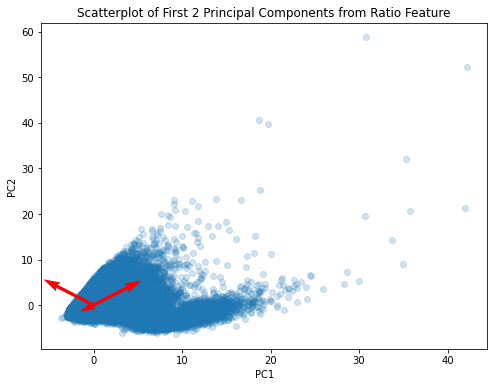

In [110]:
pc1 = r_pca.iloc[:, 0]
pc2 = r_pca.iloc[:, 1]

# The eigenvectors from the PCA object
eigenvectors = pca.components_

plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(pc1, pc2, alpha=0.2)
scale_factor = 8 #length of the eigenvector

# Adding eigenvectors scaled by the square root of the corresponding eigenvalue
for length, vector in zip(pca.explained_variance_, eigenvectors):
    v = vector * scale_factor # to scale the vectors
    plt.quiver(pca.mean_[0], pca.mean_[1], v[0], v[1], angles='xy', scale_units='xy', scale=1, color='r')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatterplot of First 2 Principal Components from Ratio Feature')

plt.show()


The normal data points will line up along the new axes' eigenvectors, which have low eigenvalues. The outliers are those high eigenvalues that far from the eigenvectors. As a result, an indicator of an outlier can be found in the large distances between each data point and its eigenvectors. The scatterplot shows the first and second principal components which capture nearly 95% of the information. The outliers are those with a wide distance from the red eigenvectors. The top right corner data cluster could be seemed as suspicious within 5% because 10% is quite high for most of the application.

**PCA: Upper Confidence Interval Feature**

In [93]:
# feature_upper
pca = PCA()
feature_upper = feature_upper.fillna(feature_upper.mean()) #since pca.fit could not handle NaN values and I want to make PCs in the same shape
u_pca = pca.fit_transform(feature_upper)
u_pca = pd.DataFrame(u_pca)
u_pca.head()

,0,1,2,3,4
0,-1.050011,-0.699630,2.271390,0.613869,6.861826e-14
1,-1.050131,-1.679921,-0.441838,-0.050313,1.445900e-17
2,-0.832097,-1.089604,-0.527661,0.612469,1.297730e-17
3,-0.849106,-1.068357,-0.357330,0.568249,1.303932e-17
4,-0.913574,-1.287536,-0.440485,0.367316,1.351295e-17


PCA provides same number of principal components as the number of original features.

In [94]:
# The upper feature variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
explained_variance

array([4.10827468e-01, 3.15237660e-01, 1.96701322e-01, 7.72335501e-02,
       5.91154509e-33])

The first principal component accounts for 41.1% of the variance, while the second and third components account for 31.5% and 19.7%. Thus, the first, second, and third principal components capture most of the information with 92.3%, which is converged to 100%.

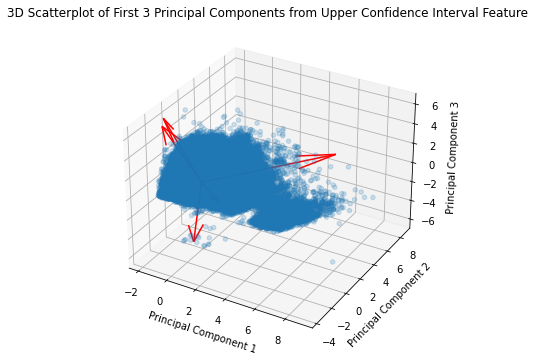

In [109]:
import numpy as np
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming pc1, pc2, pc3 are your data
pc1 = u_pca.iloc[:, 0]
pc2 = u_pca.iloc[:, 1]
pc3 = u_pca.iloc[:, 2]

# Fit the plane using multiple regression
eigenvectors = pca.components_

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(pc1, pc2, pc3, alpha=0.2)

# Plot the eigenvectors originating from the mean of the data
mean_x, mean_y, mean_z = np.mean(pc1), np.mean(pc2), np.mean(pc3)

scale_factor = 9

for v in eigenvectors:
    ax.quiver(mean_x, mean_y, mean_z, v[0]*scale_factor, v[1]*scale_factor, v[2]*scale_factor, color='red')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.title('3D Scatterplot of First 3 Principal Components from Upper Confidence Interval Feature')
plt.show()


The first 3 principal components capture nearly 92% of the information in upper confidence interval feature so I draw a 3D scatterplot to show them altogether. The outliers are those far away from the red eigenvectors. 


### KNN

**K-Nearest Neighbour Algorithm:**
1. Usually supervised machine learning method whereas its computations of the distance to the k neighbours do not need y target variable.
2. Compute the distance (e.g., Euclidean distance) to the k neighbours and use distance to define outlier scores.
3. No parameters needed to tune to make the performance better.

**Ratio Feature**

In [84]:
from pyod.models.knn import KNN
knn = KNN(contamination=0.05)

# Ratio Feature
knn.fit(feature_ratio)

# Training data
r_scores = knn.decision_function(feature_ratio)
r_pred = knn.predict(feature_ratio)


def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The ratio feature data:", count_stat(r_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , knn.threshold_)

The ratio feature data: {0: 155859, 1: 7206}
The threshold for the defined comtanimation rate: 0.4518582527344378


**Upper Confidence Interval Feature**

In [111]:
knn = KNN(contamination=0.05)

# Upper Feature
knn.fit(feature_upper)

# Training data
u_scores = knn.decision_function(feature_upper)
u_pred = knn.predict(feature_upper)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The upper feature data:", count_stat(u_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , knn.threshold_)

The upper feature data: {0: 156501, 1: 6564}
The threshold for the defined comtanimation rate: 0.2893458439245031


### Reasonable Benchmark Visualisation

Text(0.29, 0, '0.29')

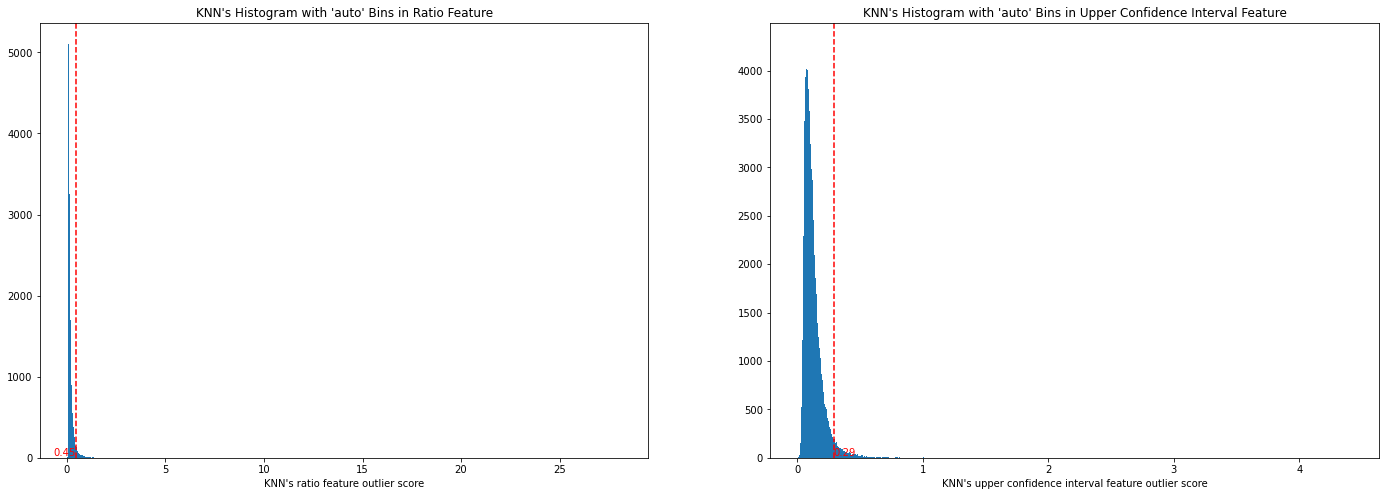

In [117]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.hist(r_scores, bins='auto')
ax1.set_title("KNN's Histogram with 'auto' Bins in Ratio Feature")
ax1.set_xlabel("KNN's ratio feature outlier score")
ax1.axvline(x=0.45, color='red', linestyle='--')
ax1.text(0.45, 0, "0.45", ha='right', va='bottom', color='red')

ax2.hist(u_scores, bins='auto')
ax2.set_title("KNN's Histogram with 'auto' Bins in Upper Confidence Interval Feature")
ax2.set_xlabel("KNN's upper confidence interval feature outlier score")
ax2.axvline(x=0.29, color='red', linestyle='--')
ax2.text(0.29, 0, "0.29", ha='left', va='bottom', color='red')

Both figures above present the outlier scores. The histogram of ratio feature on the left, which the optimal threshold can be 0.45 and if the values are greater than this benchmark, they are outliers. The right-hand side graph is the histogram of upper confidence interval feature, which the benchmark line is suggested as 0.29. The values that greater than this could be treated as outliers.

### Summary Statistics of The Normal and The Abnormal Groups

**Ratio Feature**

In [118]:
# ratio feature
threshold = knn.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)


descriptive_stat_threshold(feature_ratio, r_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,6,7,8,9,Anomaly_Score
0,Normal,143658,88.098611,-0.14,-0.14,-0.12,-0.12,-0.23,-0.23,-0.24,-0.23,-0.21,-0.21,0.13
1,Outlier,19407,11.901389,1.05,1.05,0.90,0.90,1.69,1.69,1.79,1.69,1.57,1.57,0.50


The outliers of the ratio feature occupy roughly 11.9% of the dataset with a low anomaly score 0.5, which means the observation within a dataset slightly deviates from the expected pattern.

**Upper Confidence Interval Feature**

In [119]:
threshold = knn.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)


descriptive_stat_threshold(feature_upper, u_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,Anomaly_Score
0,Normal,156501,95.974611,-0.05,-0.05,-0.05,0.03,-0.05,0.12
1,Outlier,6564,4.025389,1.17,1.17,1.13,-0.75,1.26,0.42


The outliers of the upper confidence interval feature occupy nearly 4% of the dataset with a low anomaly score 0.42, which also shows that the observations have a slight deviation from the pattern established by the majority of the data points.

### Visualise KNN Anomalous Clusters

**Ratio Feature**

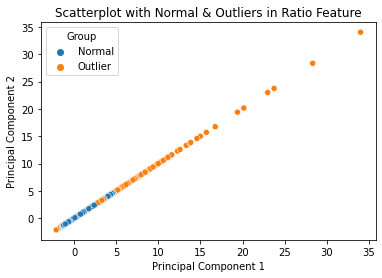

In [124]:
sns.scatterplot(x=0, y=1, hue='Group', data=feature_ratio)

plt.title('Scatterplot with Normal & Outliers in Ratio Feature')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()


If the distance to its kth nearest neighbour exceeds some threshold, an observation is considered anomalous, that’s why an isolated points are usually deemed as anomalies. To identify the clusters of outliers from KNN, the outliers show in orange in ratio feature apart from the origin but also the location far from the axes origin. 

**Upper Confidence Interval Feature**

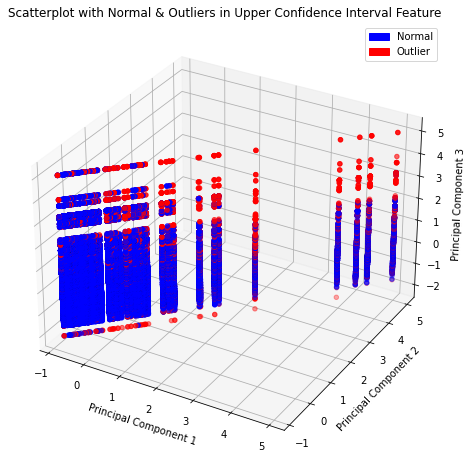

In [132]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a color map for the 'Group' column
colors = {'Normal': 'blue', 'Outlier': 'red'}

# Scatter plot with 'Group' column for color
scatter = ax.scatter(feature_upper[0], feature_upper[1], feature_upper[2], c=feature_upper['Group'].apply(lambda x: colors[x]))

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

legend_elements = [mpatches.Patch(color=color, label=group) for group, color in colors.items()]
ax.legend(handles=legend_elements, loc='best')


plt.title('Scatterplot with Normal & Outliers in Upper Confidence Interval Feature')

plt.show()


In upper confidence interval feature, the anomalous clusters mainly focus on the middle of the 3D scatterplot which are filled in red. The reason for these outliers can be a lot of reasons, for example, data collection mistake, etc.